# Final Project Submission

Please fill out:
* Student name: Akshay Ghalasi
* Student pace: self paced
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


## Setup and import data


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from scipy import stats
from scipy.stats import skew
from scipy.special import boxcox1p
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%run "Auxillary.ipynb"

In [2]:
df = pd.read_csv('kc_house_data.csv')
#understanding size of data
print(df.shape)
df.head(5)

(21597, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


## Data prepreprocessing

In [3]:
### id seems like a random assignment. we will drop it
df.drop('id',axis=1,inplace=True)

### date needs to be parsed in year, month and day. We dont expect day to carry lot of information but we will keep it for now
df['year'] = pd.DatetimeIndex(df['date']).year
df['month'] = pd.DatetimeIndex(df['date']).month
df['day'] = pd.DatetimeIndex(df['date']).day
df.drop('date',axis=1,inplace=True)


### Not all non numerical enries are stored as nans. So I am converting all non numerical entries to nan
def isnumber(x):
    try:
        float(x)
        return True
    except:
        return False

df = df[df.applymap(isnumber)]

### price is our target variable so we will leave it alone for now
### Bedroom has no NaNs
#print('Bedroom NaNs',df['bedrooms'].isna().sum())
#plt.plot(df['bedrooms'],df['price'],'bo')

### There is a bedroom with 33 rooms so with incredibly low price so we are going to remove that as an anomaly
df = df[df.bedrooms < 12]

### bathrooms has no NaNs and no obvious outliers so we will leave it alone for noe
df['bathrooms'].isna().sum()

### sqftliving, there is a clear linear relationship with a large spread. However there are clear outliers we will remove
#print('Sqftliving NaNs',df['sqft_living'].isna().sum())
#plt.plot(df['sqft_living'],df['price'],'bo')
#plt.xticks(rotation='vertical')
df = df[df.sqft_living < 11800]

### sqftlot, there no clear linear relationship. However there are clear outliers we will remove
#print('Sqftlot',df['sqft_lot'].isna().sum())
#plt.plot(df['sqft_lot'],df['price'],'bo')
#plt.xticks(rotation='vertical')
df = df[df.sqft_lot < 800000]

### Floors has no NaNs and no clear outlier. Will keep all for now
print('Floors',df['sqft_lot'].isna().sum())
df['floors'].unique()

### Waterfront has 10% nan's Only 0.1% of homes have a waterfront. We will replace nan's with zeros
df['waterfront'] = df['waterfront'].fillna(0)

### view is a little puzzling as to what it means but we will replace the nans  with the median i.e. 0
df['view'] = df['view'].fillna(df['view'].median())

### condition is an important indicator and there are no NaN's so we will leave it for the moment
#print('Condition NaN',df['condition'].isna().sum())
#plt.plot(df['condition'],df['price'],'bo')

### grade is an important indicator and has a clear linear relationship and there are no NaN's so we will leave it for the moment
#print('Grade NaN',df['grade'].isna().sum())
#plt.plot(df['grade'],df['price'],'bo')

### sqft above has a clear linear relationship and no nans so we will keep it
#print('Sqftabove NaNs',df['sqft_above'].isna().sum())
#plt.plot(df['sqft_above'],df['price'],'bo')

### sqft basement has nans which we replace with the median i.e. 0. Its also stored as strings for some reason, convert it to float
df['sqft_basement'] = df['sqft_basement'].astype(float)
df['sqft_basement'] = df['sqft_basement'].fillna(df['sqft_basement'].median())
#after normalizing by sqft_above there is no linear relationship. So we will convert it to bool
#plt.plot(df['sqft_basement']/df['sqft_above'],df['price'],'bo')

### Coverting it to categorical
df['has_bsmt'] = df['sqft_basement'].apply(lambda x: 1 if x>0.0 else 0)
df.drop('sqft_basement',axis=1,inplace=True)

#yr built has no nans so we will keep it for now
#print('yr_built NaN',df['yr_built'].isna().sum())

#if yr_renovated is 0 or nan replace it with year built # first I will convert all 0's to nan's and then replace them
df['yr_renovated'] = df['yr_renovated'].apply(lambda x: None if x==0 else x)
df['yr_renovated'].fillna(df['yr_built'],inplace=True)

#no nans in zipcode. This is the true categorical variable and an interesting one. We will deal with it later
#print('Zipcode NaNs',df['zipcode'].isna().sum())
#print('sqft_living15 NaNs',df['sqft_living15'].isna().sum())
#print('sqft_lot15 NaNs',df['sqft_lot15'].isna().sum())

Floors 0


# We will ask 3 questions in this notebook
## Q1 How well can we predict the price of the house using linear models?
## Q2 Can we make recommendations to the seller of the house regarding when to sell it?
## Q3 Can we  the give the  buyer of the house a range for his needs?

## Q1 How well can we predict the price of the house using linear models?
### Setting a benchmark

#### It is important to set a benchmark of the predictions we make to know if and why we are improving. I will use two benchmark models to predict the price of the house and see how it improves

## Benchmark 1. Linear model based on existing features without any preprocessing

Index(['price', 'sqft_living', 'grade', 'sqft_above', 'sqft_living15',
       'bathrooms', 'bedrooms', 'floors', 'yr_renovated', 'sqft_lot',
       'sqft_lot15', 'yr_built', 'condition'],
      dtype='object')
37.926901907322495
The mean of the percent error in log predictions is 0.02229974164838866 The std of the percent error in log predictions is 0.03027332880091603 The rmse error in log predictions is 0.3875158727013281


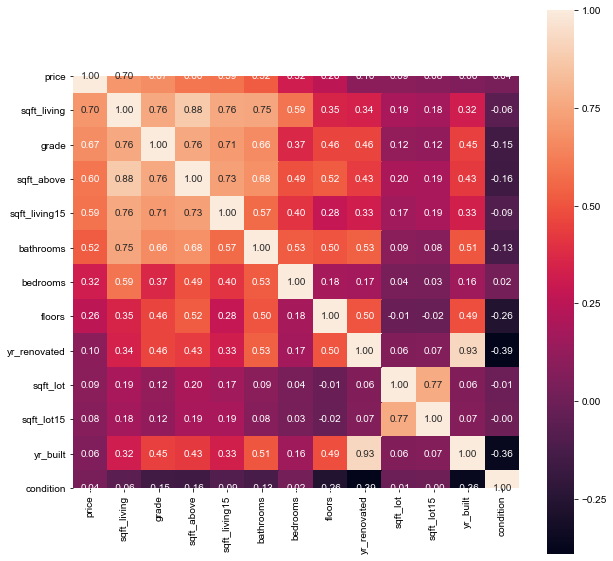

In [4]:
## Here I will create a list of features that have not been preprocessed and make a linear fit.
## First I chose features such that I expect them to have a linear relationship with the target
lin_feats = ['price','bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
        'condition', 'grade', 'sqft_above', 'yr_built',
       'yr_renovated', 'sqft_living15', 'sqft_lot15']
ben_1_df = df[lin_feats]

## Lets get a corrmat to figure out what the most important variables are
print(plot_corr(ben_1_df))

## Here I will create a list of features that have not been preprocessed and make a linear fit.
## First I chose features such that I expect them to have a linear relationship with the target
y = ben_1_df['price']
X = ben_1_df.drop('price',axis=1)

## Making a linear fit. First do a train-test split, then fit on train using sklearn linear model and testing predictions on test

# Making a train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)


# Doing Ridge regression
ridge = RidgeCV(alphas=np.logspace(0,3,20)).fit(X_train, y_train)
#Predict on training data
pred = ridge.predict(X_train)
#Preddict on Test data
testpred = ridge.predict(X_test)
alpha = ridge.alpha_
print(alpha)
#Calculate rmse
testpred[testpred < 0] = np.mean(y_train)
benchmark_1 = [(np.abs(((np.log1p(testpred)-np.log1p(y_test))/np.log1p(y_test)))).mean(),((np.log1p(testpred)-np.log1p(y_test))/np.log1p(y_test)).std(),
               np.sqrt(((np.log1p(testpred)-np.log1p(y_test))**2).sum()/len(y_test))]
print('The mean of the percent error in log predictions is',benchmark_1[0],
     'The std of the percent error in log predictions is',benchmark_1[1],
     'The rmse error in log predictions is',benchmark_1[2])


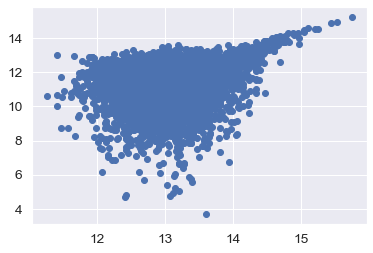

In [5]:
plt.plot(np.log1p(y_test),np.log1p(np.abs(testpred-y_test)),'bo');

## Benchmark 2. Groupby zipcode, Find average house cost/sqft in the zipcode and multipy by sqft living

The mean of the percent error in log predictions is 0.014448805635258978 The std of the percent error in log predictions is 0.018983572118085643 The rmse error in log predictions is 0.24868308950792248


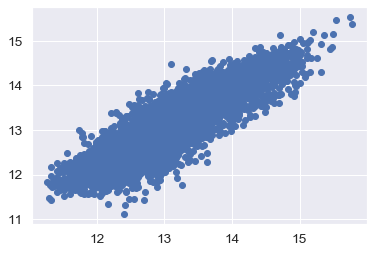

In [6]:
# I dont do a train test split here since this is a simple prediction
df['pricepersqft'] = df['price']/df['sqft_living']

df['pricepersqft_mean'] = df.groupby(['zipcode'])['pricepersqft'].transform('mean') 

testpred = df['pricepersqft_mean']*df['sqft_living']
benchmark_2 = [(np.abs(((np.log1p(testpred)-np.log1p(df['price']))/np.log1p(df['price'])))).mean(),
               ((np.log1p(testpred)-np.log1p(df['price']))/np.log1p(df['price'])).std(),
               np.sqrt(((np.log1p(testpred)-np.log1p(df['price']))**2).sum()/len(df['price']))]
print('The mean of the percent error in log predictions is',benchmark_2[0],
     'The std of the percent error in log predictions is',benchmark_2[1],
     'The rmse error in log predictions is',benchmark_2[2])

plt.plot(np.log1p(df['price']),np.log1p(testpred),'bo');

### Benchmark 2 is the one to beat. Lets see if we can make sequential improvements to our predictions to improve the result

## Log transform target and skewed features to get better distrubutions. I will use Ridge regression throughout

Index(['price', 'grade', 'sqft_living', 'sqft_living15', 'sqft_above',
       'bathrooms', 'bedrooms', 'floors', 'sqft_lot', 'sqft_lot15',
       'yr_renovated', 'yr_built', 'condition'],
      dtype='object')
0.11288378916846889
The mean of the percent error in log predictions is 0.019104061313768735 The std of the percent error in log predictions is 0.02412715746080248 The rmse error in log predictions is 0.3134359749013579


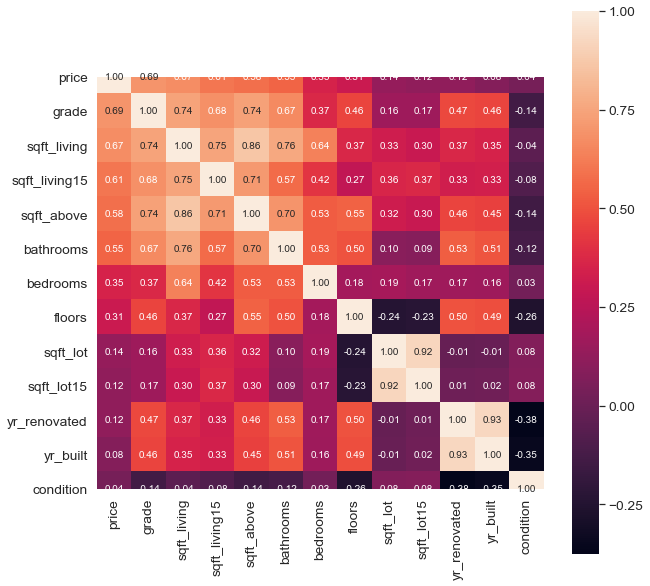

In [7]:
['price','bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
        'condition', 'grade', 'sqft_above', 'yr_built',
       'yr_renovated', 'sqft_living15', 'sqft_lot15']
df_log = fix_skewed(df,lin_feats)

## Lets see the cormat again. It chages a little bit
print(plot_corr(df_log))

# The improvement after taking a log transformation is only a modest one
y = df_log['price']
X = df_log.drop('price',axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

ridge = RidgeCV(alphas=np.logspace(-2,3,20)).fit(X_train, y_train)
#Predict on training data
pred = ridge.predict(X_train)
#Preddict on Test data
testpred = ridge.predict(X_test)
alpha = ridge.alpha_
print(alpha)    

log_err = [(np.abs((testpred-y_test)/y_test)).mean(),((testpred-y_test)/y_test).std(),
               np.sqrt(((testpred-y_test)**2).sum()/len(y_test))]
print('The mean of the percent error in log predictions is',log_err[0],
     'The std of the percent error in log predictions is',log_err[1],
     'The rmse error in log predictions is',log_err[2])


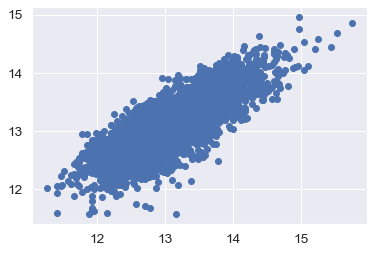

In [8]:
plt.plot(y_test,testpred,'bo');

### Checking to see if behavior is still monotonic

[0.37718757000556263, 0.35728772448612534, 0.3555637018495611, 0.3529232482513147, 0.35292616694941614, 0.3525042386768673, 0.35251549856704584, 0.35097512278622545, 0.3502133196774699, 0.3237748236895589, 0.31422423746779843, 0.3134619071656421]


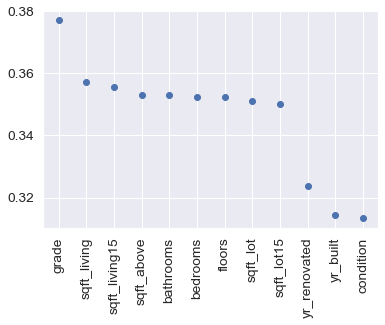

In [9]:
el = []
for x in range(1,df_log.shape[1]):
    e,l,ae = withnfeatures(df_log,x)
    el.append(e)
labels = withnfeatures(df_log,x)[1]
print(el)
plt.plot(range(1,df_log.shape[1]),el,'bo');
plt.xticks(range(1,df_log.shape[1]), labels, rotation='vertical');


#### It is decreasing monotonically

### We will try two different methods with zipcode. First we will convert zipcode categorical data to numerical. The cattonum function orders the data in ascending order by zipcode and assigns an integer value to build a monotonic relationship

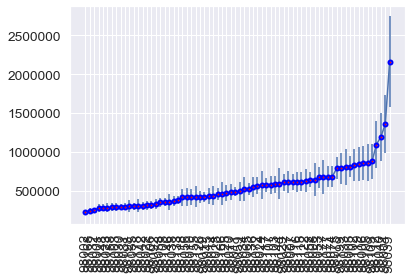

In [10]:
df_zipc = cattonum(df,'zipcode','price')

### Now to do linear regression using zipcode as a continuous variabe

In [11]:
lin_feats = ['price','bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
        'condition', 'grade', 'sqft_above', 'yr_built',
       'yr_renovated', 'sqft_living15', 'sqft_lot15','zipcode']

df_log = fix_skewed(df_zipc,lin_feats)

y = df_log['price']
X = df_log.drop('price',axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

ridge = RidgeCV(alphas=np.logspace(-2,3,20)).fit(X_train, y_train)
#Predict on training data
pred = ridge.predict(X_train)
#Preddict on Test data
testpred = ridge.predict(X_test)
alpha = ridge.alpha_
#print(alpha)    

log_err = [(np.abs((testpred-y_test)/y_test)).mean(),((testpred-y_test)/y_test).std(),
               np.sqrt(((testpred-y_test)**2).sum()/len(y_test))]
print('The mean of the percent error in log predictions is',log_err[0],
     'The std of the percent error in log predictions is',log_err[1],
     'The rmse error in log predictions is',log_err[2])


The mean of the percent error in log predictions is 0.012625700636812193 The std of the percent error in log predictions is 0.01687318638100085 The rmse error in log predictions is 0.2209261897495317


#### We get a huge improvement

## Does getdummies work as well or better for zipcode?

In [12]:
lin_feats = ['price','bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
        'condition', 'grade', 'sqft_above', 'yr_built',
       'yr_renovated', 'sqft_living15', 'sqft_lot15','zipcode']

df_dummies = fix_skewed(df,lin_feats)
df_dummies = pd.get_dummies(df_dummies, columns=['zipcode'],drop_first=True)

y = df_dummies['price']
X = df_dummies.drop('price',axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

ridge = RidgeCV(alphas=np.logspace(-3,3,20)).fit(X_train, y_train)
#Predict on training data
pred = ridge.predict(X_train)
#Preddict on Test data
testpred = ridge.predict(X_test)
alpha = ridge.alpha_
#print(alpha)    

log_err = [(np.abs((testpred-y_test)/y_test)).mean(),((testpred-y_test)/y_test).std(),
               np.sqrt(((testpred-y_test)**2).sum()/len(y_test))]
print('The mean of the percent error in log predictions is',log_err[0],
     'The std of the percent error in log predictions is',log_err[1],
     'The rmse error in log predictions is',log_err[2])

The mean of the percent error in log predictions is 0.01070180407015352 The std of the percent error in log predictions is 0.014810104814676173 The rmse error in log predictions is 0.19308817054558705


#### One hot encoding does slightly better. Now let's add more features

In [13]:
lin_feats = ['price','bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
        'condition', 'grade', 'sqft_above', 'yr_built',
       'yr_renovated', 'sqft_living15', 'sqft_lot15','zipcode','month','has_bsmt','view','waterfront']

df_dummies = fix_skewed(df,lin_feats)
df_dummies = pd.get_dummies(df_dummies, columns=['zipcode','month'],drop_first=True)

y = df_dummies['price']
X = df_dummies.drop('price',axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

ridge = RidgeCV(alphas=np.logspace(-3,3,20)).fit(X_train, y_train)
#Predict on training data
pred = ridge.predict(X_train)

#Preddict on Test data
testpred = ridge.predict(X_test)
alpha = ridge.alpha_
# print(alpha)    

log_err = [(np.abs((testpred-y_test)/y_test)).mean(),((testpred-y_test)/y_test).std(),
               np.sqrt(((testpred-y_test)**2).sum()/len(y_test))]
print('The mean of the percent error in log predictions is',log_err[0],
     'The std of the percent error in log predictions is',log_err[1],
     'The rmse error in log predictions is',log_err[2])

The mean of the percent error in log predictions is 0.010086839046675759 The std of the percent error in log predictions is 0.013906729456529045 The rmse error in log predictions is 0.1799633606340985


#### Including month information by one hot encoding does sllghtly better. So does including has_bsmt

## Q2 Can we make recommendations to the seller of the house regarding when to sell it?

#### Typically the sellers of the house only knows the zipcode they are in and maybe the grade of their house. Can we make recommendations regarding when to sell the house based on that information? We will group the data by zipcode and grade and estimate when to sell the house. We define the function below

In [15]:
def predict_time(data,zipc,grade=5):
    ## first groupby and transform to find the mean and std
    ## We will be plotting pricepersqft to get rid of dependence on sqft
    if zipc not in data['zipcode'].unique():
        raise ValueError('Invalid Zipcode')
        return None
    if grade not in data['grade'].unique():
        raise ValueError('Invalid Grade')
        return None
    month = {1:'Jan',2:'Feb',3:'Mar',4:'April',5:'May',6:'June',7:'July',8:'Aug',9:'Sept',10:'Oct',11:'Nov',12:'Dec'}
    data['pricepersqft'] = data['price']/data['sqft_living']
    
    gb_zip = df.groupby('zipcode')
    month_mean = ((gb_zip.get_group(zipc)).groupby(['month']).mean())['pricepersqft']
    month_std = ((gb_zip.get_group(zipc)).groupby(['month']).std())['pricepersqft']
    
    newfigure = plt.figure(figsize=(20,10))
    ax = newfigure.add_subplot(121)
    ax2 = newfigure.add_subplot(122)
    
    ax.errorbar(month_mean.index, month_mean, 0.5*month_std, marker='o', mfc='red',
        mec='blue', ms=2, mew=4);
    labels = list(month.values())
    ax.set_title('For your zipcode')
    ax.set(ylabel='price/sqft')
#    ax.ylabel('price/sqft')
    ax.set_xticks(list(month.keys()),labels)

    if grade in (gb_zip.get_group(zipc))['grade'].unique():
        gb_zip_grade = ((gb_zip.get_group(zipc)).groupby(['grade']))
        month_mean = ((gb_zip_grade.get_group(grade)).groupby(['month']).mean())['pricepersqft']
        month_std = ((gb_zip_grade.get_group(grade)).groupby(['month']).std())['pricepersqft']
        ax2.errorbar(month_mean.index, month_mean, 0.5*month_std, marker='o', mfc='red',
             mec='blue', ms=2, mew=4);
        labels = list(month.values())
        ax2.set_title('For your zipcode and grade')
        ax2.set(ylabel='price/sqft')
        ax2.set_xticks(list(month.keys()), labels);
    else:
        print("Not enough data for grade,making predictions on zipcode alone. Try neighboring grade values")
    worst = np.argmin(month_mean)
    best = np.argmax(month_mean)
    
    print('Check the plots to verify, plot shows std. deviation for the relevant selections')
    print('The best month to sell your house is', month.get(best))
    print('The worst month to sell your house is', month.get(worst))
    return best,worst 
    

Check the plots to verify, plot shows std. deviation for the relevant selections
The best month to sell your house is Mar
The worst month to sell your house is Dec


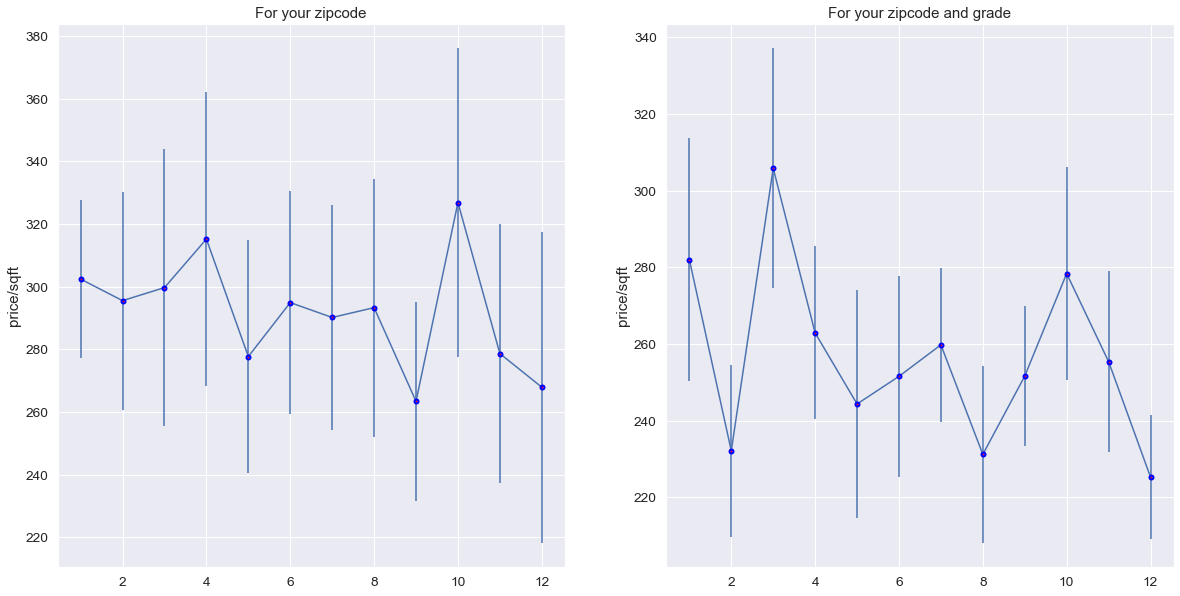

In [16]:
predict_time(df,df['zipcode'].unique()[13],df['grade'].unique()[2]);

## Q3 Can we  the give the  buyer of the house a list of houses for his needs?

### The buyer will need to specify the distance from the position he gave

In [19]:
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'yr_built',
       'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15',
       'year', 'month', 'day', 'has_bsmt', 'pricepersqft',
       'pricepersqft_mean'],
      dtype='object')

In [21]:
from math import sin, cos, sqrt, atan2, radians
def get_dist(pos1,pos2):
    ## Found the code on stack overflow and modified it
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(pos1[0])
    lon1 = radians(pos1[1])
    lat2 = radians(pos2[0])
    lon2 = radians(pos2[1])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    ## return distance in miles
    return round(distance*(0.6213),1)

In [22]:
get_dist([52.2296756,21.0122287],[52.406374,16.9251681])

173.1

In [26]:
df['lat_long'] = list(zip(df.lat, df.long))


In [30]:
pos1 = df['lat_long'].iloc[0]

In [32]:
df['distance_pos'] = [get_dist(pos1,pos2) for pos2 in df['lat_long']]

In [33]:
df['distance_pos']

0         0.0
1        14.8
2        15.7
3         6.4
4        12.3
         ... 
21592    13.6
21593     4.9
21594     6.1
21595     8.9
21596     6.1
Name: distance_pos, Length: 21583, dtype: float64

In [107]:
def get_range(pos,dist,bedrooms_min=0,bathrooms_min=1,price_min=0, price_max= 10**9,sqft_living_min=0,sqft_lot_min=0,has_bsmt=None,waterfront=None,view=None,df=df):
    df_ans = df.copy()
    #first find distances
    df_ans['distance'] = [get_dist(pos1,pos2) for pos2 in df['lat_long']]
    # select based on distances
    df_ans = df_ans[df_ans['distance'] < dist]
    
    #select based on other features
    df_ans = df_ans[df_ans['bedrooms'] >= bedrooms_min]
    df_ans = df_ans[df_ans['bathrooms'] >= bathrooms_min]

    df_ans = df_ans[(price_min <= df_ans['price']) & (df_ans['price']<= price_max)]
    df_ans = df_ans[df_ans['sqft_living'] >= sqft_living_min]
    df_ans = df_ans[df_ans['sqft_lot'] >= sqft_lot_min]
    
    if has_bsmt !=None:
        df_ans = df_ans[df_ans['has_bsmt']==has_bsmt]
    if waterfront !=None:
        df_ans = df_ans[df_ans['waterfront']==waterfront]
    if view !=None:
        df_ans = df_ans[df_ans['view'] == view]
        
    if(len(df_ans)==0):
        print('No matches found for your selection. Try alternate criterion')
    dat = df_ans.groupby('zipcode').mean()['price']
    print('The zipcode and expected price of your selection')
    print(pd.DataFrame(dat.sort_values()))
    return df_ans

In [109]:
ans = get_range(df['lat_long'].iloc[0],10,bedrooms_min=4,bathrooms_min=3,price_max=10**6,sqft_living_min=5000,sqft_lot_min=5000,has_bsmt=1)

The zipcode and expected price of your selection
            price
zipcode          
98058    782000.0
98031    800000.0
98166    800000.0
98006    900000.0
98027    957500.0
98005    975000.0
